# Exploration des données OpenFoodFacts

Ce notebook permet d'explorer les données récupérées par le pipeline.


In [14]:
# Configuration de l'environnement
import sys
from pathlib import Path

# Ajouter le répertoire parent au path pour importer les modules du pipeline
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Imports
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration des graphiques
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Bibliothèques importées avec succès")
print(f"📁 Répertoire du projet : {project_root}")


✅ Bibliothèques importées avec succès
📁 Répertoire du projet : D:\IPSSI\Open data\TP2


## Chargement des données Parquet


In [15]:
# Configuration : choisir la catégorie à analyser
# Modifiez cette variable pour changer de catégorie
CATEGORY_NAME = "boissons_fr"  # Exemples: "chocolats_fr", "biscuits_fr", "chocolats_fr", etc.

# Charger le fichier Parquet correspondant
processed_dir = project_root / "data" / "processed"

# Chercher le fichier le plus récent correspondant au nom
if CATEGORY_NAME:
    parquet_files = sorted(processed_dir.glob(f"{CATEGORY_NAME}_*.parquet"))
else:
    # Si pas de nom spécifique, prendre le plus récent
    parquet_files = sorted(processed_dir.glob("*.parquet"))

if parquet_files:
    latest_file = parquet_files[-1]
    print(f"📂 Chargement de : {latest_file.name}")
    df = pd.read_parquet(latest_file)
    print(f"✅ Shape : {df.shape[0]} lignes, {df.shape[1]} colonnes")
    print(f"📋 Colonnes : {', '.join(df.columns[:5])}...")
    print(f"\n💡 Pour changer de catégorie, modifiez CATEGORY_NAME ci-dessus")
    print(f"   Exemples: 'biscuits_fr', 'boissons_fr', 'yaourts_fr'")
else:
    print("⚠️  Aucun fichier Parquet trouvé.")
    print(f"   Exécutez d'abord le pipeline :")
    print(f"   uv run python -m pipeline.main --category {CATEGORY_NAME.split('_')[0] if '_' in CATEGORY_NAME else 'chocolats'} --name {CATEGORY_NAME}")


📂 Chargement de : boissons_fr_20251216_162846.parquet
✅ Shape : 72 lignes, 15 colonnes
📋 Colonnes : brands, categories, code, countries_tags, energy_100g...

💡 Pour changer de catégorie, modifiez CATEGORY_NAME ci-dessus
   Exemples: 'biscuits_fr', 'boissons_fr', 'yaourts_fr'


## Exploration avec DuckDB


In [16]:
# Connexion DuckDB
con = duckdb.connect()

# Statistiques générales
if parquet_files:
    stats = con.execute(f"""
        SELECT 
            COUNT(*) as total_produits,
            COUNT(DISTINCT brands) as marques_uniques,
            COUNT(DISTINCT categories) as categories_uniques,
            AVG(energy_100g) as energie_moyenne,
            AVG(sugars_100g) as sucres_moyens,
            AVG(fat_100g) as matieres_grasses_moyennes
        FROM read_parquet('{latest_file}')
    """).df()
    
    print("Statistiques générales :")
    print(stats.T)


Statistiques générales :
                                    0
total_produits              72.000000
marques_uniques             66.000000
categories_uniques          65.000000
energie_moyenne            177.765300
sucres_moyens                6.670871
matieres_grasses_moyennes    0.606292


## Analyse du Nutri-Score


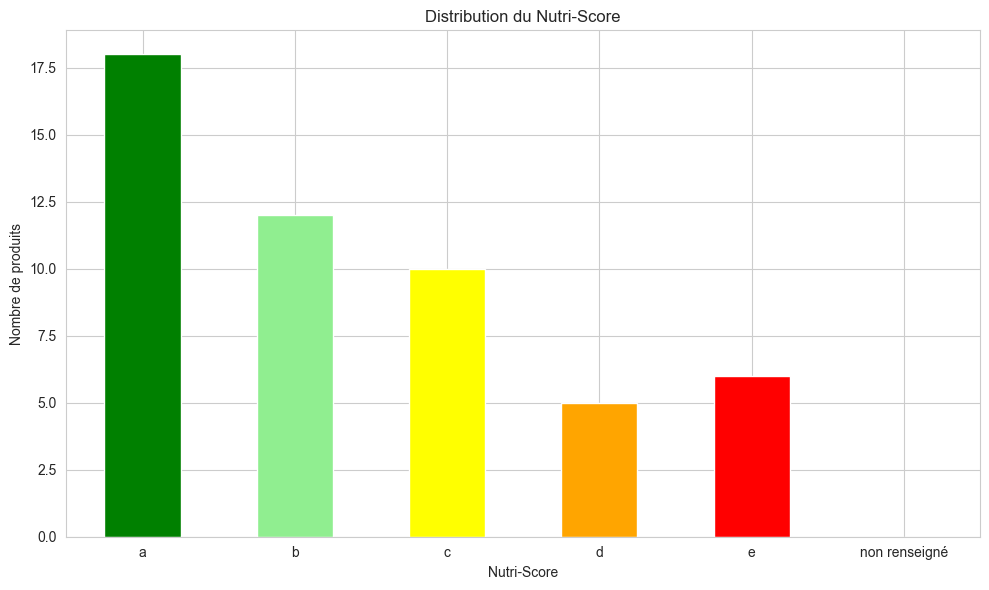


Répartition :
nutriscore_grade
a                18
b                12
c                10
d                 5
e                 6
non renseigné     0
Name: count, dtype: int64


In [17]:
# Distribution du Nutri-Score
if 'nutriscore_grade' in df.columns:
    nutri_counts = df['nutriscore_grade'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    nutri_counts.plot(kind='bar', color=['green', 'lightgreen', 'yellow', 'orange', 'red'])
    plt.title('Distribution du Nutri-Score')
    plt.xlabel('Nutri-Score')
    plt.ylabel('Nombre de produits')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("\nRépartition :")
    print(nutri_counts)


## Analyse nutritionnelle


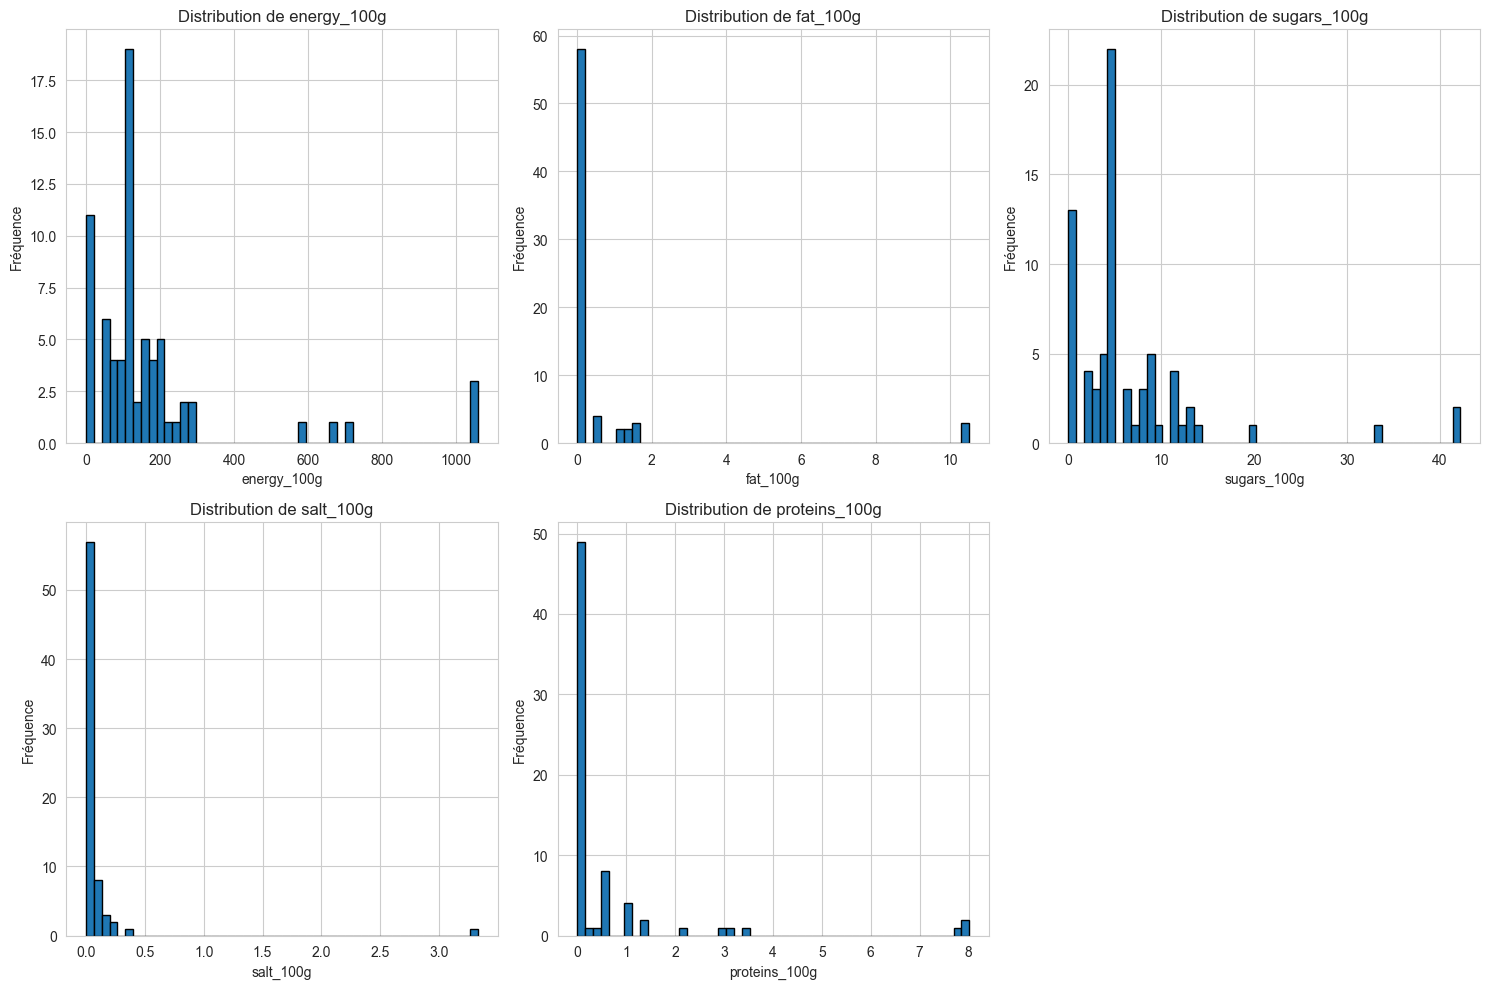

In [18]:
# Distribution des valeurs nutritionnelles
nutrition_cols = ['energy_100g', 'fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g']
nutrition_cols = [col for col in nutrition_cols if col in df.columns]

if nutrition_cols:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(nutrition_cols):
        if i < len(axes):
            df[col].hist(bins=50, ax=axes[i], edgecolor='black')
            axes[i].set_title(f'Distribution de {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Fréquence')
    
    # Masquer les axes non utilisés
    for i in range(len(nutrition_cols), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


## Top 10 des marques


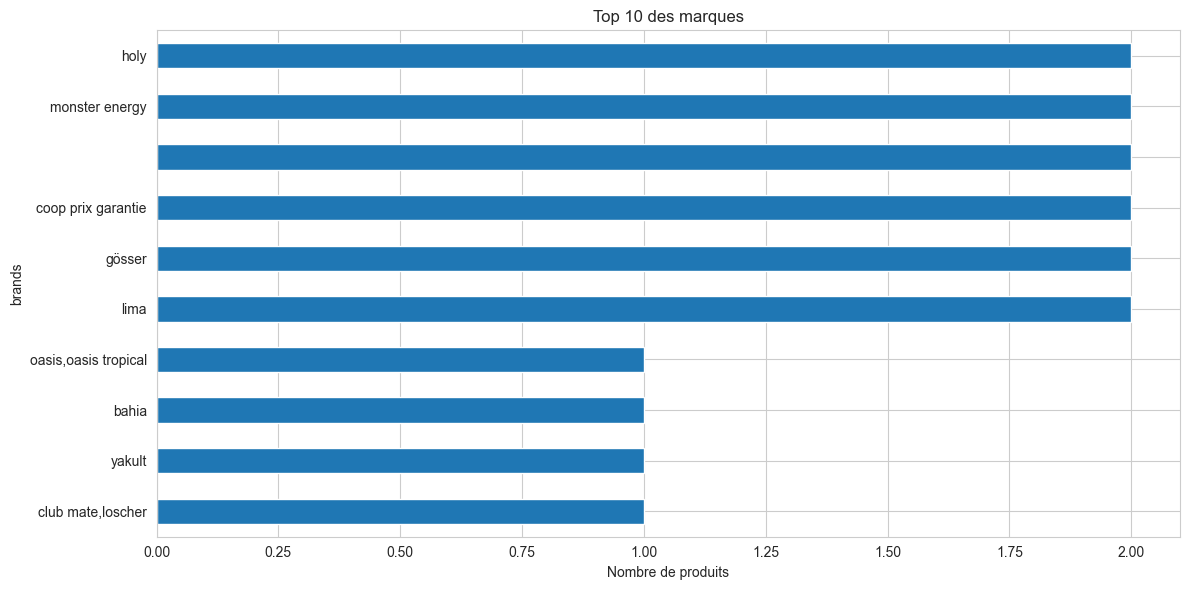


Top 10 des marques :
brands
holy                    2
monster energy          2
                        2
coop prix garantie      2
gösser                  2
lima                    2
oasis,oasis tropical    1
bahia                   1
yakult                  1
club mate,loscher       1
Name: count, dtype: int64


In [19]:
if 'brands' in df.columns:
    top_brands = df['brands'].value_counts().head(10)
    
    plt.figure(figsize=(12, 6))
    top_brands.plot(kind='barh')
    plt.title('Top 10 des marques')
    plt.xlabel('Nombre de produits')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 des marques :")
    print(top_brands)


## Qualité des données


Valeurs manquantes par colonne :
                  Valeurs manquantes  Pourcentage
nutriscore_grade                  21    29.166667


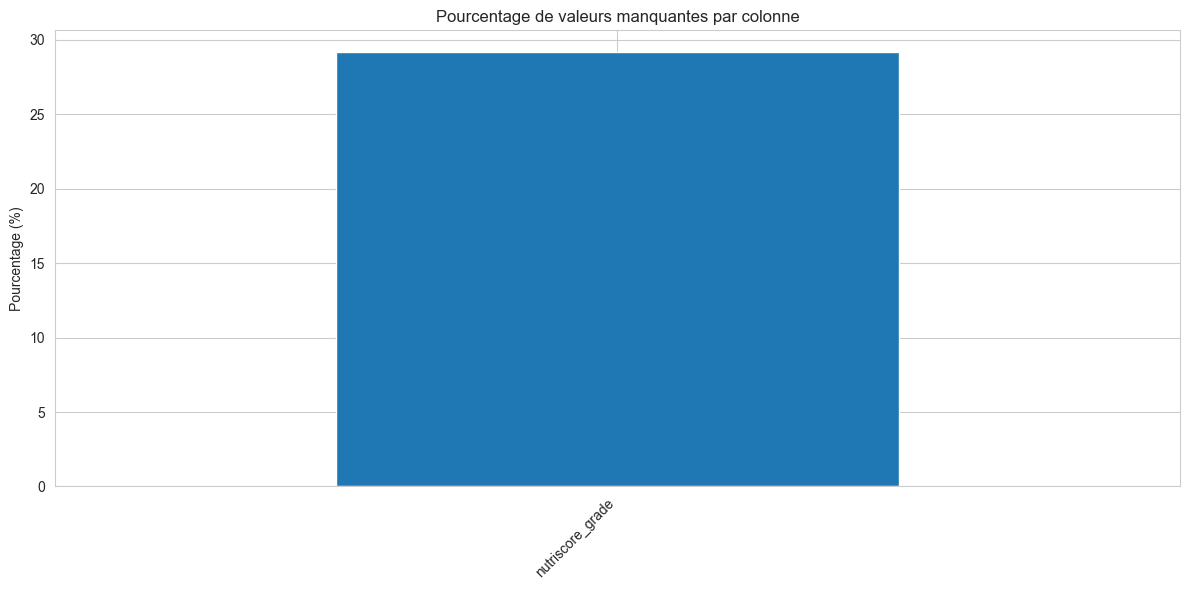

In [20]:
# Valeurs manquantes
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Valeurs manquantes': missing,
    'Pourcentage': missing_pct
}).sort_values('Valeurs manquantes', ascending=False)

print("Valeurs manquantes par colonne :")
print(missing_df[missing_df['Valeurs manquantes'] > 0])

# Visualisation
if missing.sum() > 0:
    plt.figure(figsize=(12, 6))
    missing_pct[missing_pct > 0].plot(kind='bar')
    plt.title('Pourcentage de valeurs manquantes par colonne')
    plt.ylabel('Pourcentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


## Requêtes SQL avec DuckDB


In [21]:
# Produits avec le meilleur Nutri-Score
if parquet_files:
    best_nutri = con.execute(f"""
        SELECT 
            product_name,
            brands,
            nutriscore_grade,
            sugars_100g,
            fat_100g
        FROM read_parquet('{latest_file}')
        WHERE nutriscore_grade = 'a'
        ORDER BY sugars_100g ASC
        LIMIT 10
    """).df()
    
    print("Top 10 produits avec Nutri-Score A (moins de sucres) :")
    print(best_nutri)


Top 10 produits avec Nutri-Score A (moins de sucres) :
                    product_name              brands nutriscore_grade  \
0              hafer ohne zucker              oatly!                a   
1          natural mineral water              volvic                a   
2             tónica cero azúcar         nordic mist                a   
3           eska sparkling lemon                                    a   
4                                               holy                a   
5  japanisches kirschblüten-fest            teekanne                a   
6             helles alkoholfrei              hirsch                a   
7               alkoholfrei herb          warsteiner                a   
8                                            solimon                a   
9  balance juicy pink grapefruit  vöslauer, vöslauer                a   

   sugars_100g  fat_100g  
0          0.0       1.5  
1          0.0       0.0  
2          0.0       0.0  
3          0.0       0.0  
4     